## 1) Laplace equation:  


In [225]:
%%writefile laplace.cu


#include <stdio.h>



const long int N = 1<<8;
const long int L = N * N;


__global__ void Init(long int n, float * d_a, float heat)
{
    int x = blockIdx.x, y = threadIdx.x;
    int globalIdx = x * blockDim.x + y;

    if(globalIdx < n) { 
        if(x != 0) {
            d_a[globalIdx] = 0;
        }
        else {
            
            if((y == 0) | (y ==  N-1)) {
                d_a[globalIdx] = 0;
            }
            else {
                d_a[globalIdx] = heat;
            }
        }
    }  
}



__global__ void Step(long int n, float * d_old, float * d_new)
{
    int x = blockIdx.x, y = threadIdx.x;
    int globalIdx = x * blockDim.x + y;
    int upper, down, right, left;

    if(globalIdx < n)
    { 
        if((x != 0) && (x !=  N-1))
        {
            if((y != 0) && (y !=  N-1))
            {
                right = (x + 1) * blockDim.x + y;
                left = (x - 1) * blockDim.x + y;
             
                upper = x * blockDim.x + y+1;
                down = x * blockDim.x + y-1;
             
                d_new[globalIdx] = (d_old[upper] + d_old[down] + d_old[right] + d_old[left]) / 4;
                d_old[globalIdx] = d_new[globalIdx];
            }
        }
    }  
}



// CPU code
int main()
{
    float * d_old;
    float * d_new;



    FILE *fp;
    fp = fopen("heatmap.txt","w");

    cudaMallocManaged(&d_old, sizeof(float)*L);
    cudaMallocManaged(&d_new, sizeof(float)*L);


    Init<<<N,N>>>(L, d_old, 1);
    Init<<<N,N>>>(L, d_new, 1);


    for(int step=0; step < 100000; step++) 

        {
            if (step % 100 == 0) {
                cudaDeviceSynchronize();
            }   
         Step<<<N,N>>>(L, d_old, d_new);   
        }
        
        

    

    cudaDeviceSynchronize();

    for(int j=0; j<N; j++)
    {
        for (int i=0; i<N; i++)
        {
            fprintf(fp, "%f ", d_new[i + j*N]);
        }
        fprintf(fp, "\n");
    }

    cudaDeviceSynchronize();

    cudaFree(d_new);
    cudaFree(d_old);

    fclose(fp);
    return 0;
}

Overwriting laplace.cu


In [226]:
!nvcc laplace.cu -o out

In [227]:
!./out

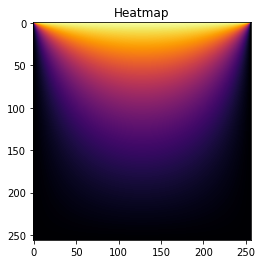

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


with open("heatmap.txt", 'r') as file:
    heatmap = pd.DataFrame(np.genfromtxt(file, skip_header=0))
heatmap  = np.array(heatmap )
plt.imshow(heatmap, cmap='inferno')
plt.title('Heatmap')
plt.show()

## 2) Filtering:



### Blured

(600, 600, 3)


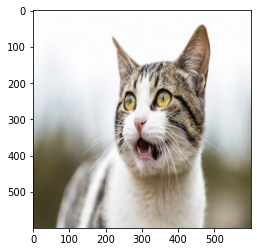

In [162]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import image
import PIL
from PIL import Image
img = Image.open('cat.jpg')
img = img.resize((600, 600), Image.ANTIALIAS)
img.save('cat.jpg')


img = image.imread('cat.jpg')

img = np.array(img)/255

plt.imshow(img)
print(img.shape)
plt.show()

In [163]:

cat_r = pd.DataFrame(img[:, :, 0])
cat_r.to_csv(r'cat_r.txt', header=None, index=None, sep=' ')

cat_g = pd.DataFrame(img[:, :, 1])
cat_g.to_csv('cat_g.txt', header=None, index=None, sep=' ')

cat_b = pd.DataFrame(img[:, :, 2])
cat_b.to_csv(r'cat_b.txt', header=None, index=None, sep=' ')

In [186]:
%%writefile blur.cu

#include <stdio.h>
// kernel

const long int size = 600;
const long int N = size*size;


__global__ void Init(long int n, float * d_a)
{
    int globalIdx = threadIdx.z * blockDim.x * blockDim.y + threadIdx.y * blockDim.x + threadIdx.x;

    if(globalIdx < n) d_a[globalIdx] = globalIdx;
}


__global__ void Blur(long int n,  float * d_old, float * d_new)
{
    int x = blockIdx.x;
    int y = threadIdx.x;
    int globalIdx = x * blockDim.x + y;
    int up, down, right, left;
    int u_l, d_l, u_r, d_r;

    if(globalIdx < n)
    { 
        if((x != 0) && (x !=  size-1))
        {
            if((y != 0) && (y !=  size-1))
            {
                d_r   = (x + 1) * blockDim.x + y - 1;
                right = (x + 1) * blockDim.x + y;
                u_r   = (x + 1) * blockDim.x + y + 1;
                
                d_l =  (x - 1) * blockDim.x + y - 1;
                left = (x - 1) * blockDim.x + y;
                u_l =  (x - 1) * blockDim.x + y + 1;

                up = x * blockDim.x + y+1;
                down = x * blockDim.x + y-1;
                                
                d_new[globalIdx] = (d_old[globalIdx] + d_old[up] + d_old[down] + d_old[left] +\
                                    d_old[right] + d_old[u_l] + d_old[d_l] + d_old[u_r] + d_old[d_r]) / 9.0;
                d_old[globalIdx] = d_new[globalIdx];
            }
        }
    }  
}



int main()
{
    float * d_r;
    float * d_g;
    float * d_b;
    float * d_new;
   
    cudaMalloc(&d_r, sizeof(float)*N);
    cudaMalloc(&d_g, sizeof(float)*N);
    cudaMalloc(&d_b, sizeof(float)*N);
    cudaMalloc(&d_new, sizeof(float)*N);

    float * h_r = (float *)malloc(sizeof(float)*N);
    float * h_g = (float *)malloc(sizeof(float)*N);
    float * h_b = (float *)malloc(sizeof(float)*N);


    FILE *init_r, *init_g, *init_b, *out_r, *out_g, *out_b;
    init_r = fopen("cat_r.txt","r");
    init_g = fopen("cat_g.txt","r");
    init_b = fopen("cat_b.txt","r");

    out_r = fopen("blur_cat_r.txt","w");
    out_g = fopen("blur_cat_g.txt","w");
    out_b = fopen("blur_cat_b.txt","w");


    for(int i = 0; i < size; i++) {
        for(int j = 0; j < size; j++) {
            fscanf(init_r, "%f", &h_r[i*size + j]);
            fscanf(init_g, "%f", &h_g[i*size + j]);
            fscanf(init_b, "%f", &h_b[i*size + j]);
        }
    }

    cudaMemcpy(d_r, h_r, sizeof(float)*N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_g, h_g, sizeof(float)*N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeof(float)*N, cudaMemcpyHostToDevice);


    for(int i = 0; i < 250; i++) {
        
        Blur<<<size,size>>>(N, d_r, d_new);
 
        Blur<<<size,size>>>(N, d_g, d_new);

        Blur<<<size,size>>>(N, d_b, d_new);

    }

    cudaMemcpy(h_r, d_r, sizeof(float)*N, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_g, d_g, sizeof(float)*N, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_b, d_b, sizeof(float)*N, cudaMemcpyDeviceToHost);

    cudaDeviceSynchronize();

    for(int i = 0; i < size; i++) {
        for(int j = 0; j < size; j++) {
            fprintf(out_r, "%f ", h_r[i*size + j]);
            fprintf(out_g, "%f ", h_g[i*size + j]);
            fprintf(out_b, "%f ", h_b[i*size + j]);
        }
        
        fprintf(out_r, "\n"); 
        fprintf(out_g, "\n"); 
        fprintf(out_b, "\n"); 
    }

    cudaDeviceSynchronize();
    
    fclose(init_r);
    fclose(init_g);
    fclose(init_b);
    
    fclose(out_r);
    fclose(out_g);
    fclose(out_b);
    
    cudaFree(d_r);
    cudaFree(d_g);
    cudaFree(d_b);
    cudaFree(d_new);

    free(h_r);
    free(h_g);
    free(h_b);

    return 0;
}

Overwriting blur.cu


In [187]:
!nvcc blur.cu -o ./out

In [188]:
!./out

In [214]:
with open('blur_cat_r.txt', 'r') as file:
   blur_cat_r = pd.DataFrame(np.genfromtxt(file,  skip_header=0))

with open('blur_cat_g.txt', 'r') as file:
   blur_cat_g = pd.DataFrame(np.genfromtxt(file,  skip_header=0))

with open('blur_cat_b.txt', 'r') as file:
   blur_cat_b = pd.DataFrame(np.genfromtxt(file,  skip_header=0))


In [166]:
blured_img = np.zeros(img.shape)
blured_img[:,:,0] = np.array(blur_cat_r)
blured_img[:,:,1] = np.array(blur_cat_g)
blured_img[:,:,2] = np.array(blur_cat_b)

In [215]:
more_blured_img = np.zeros(img.shape)
more_blured_img[:,:,0] = np.array(blur_cat_r)
more_blured_img[:,:,1] = np.array(blur_cat_g)
more_blured_img[:,:,2] = np.array(blur_cat_b)

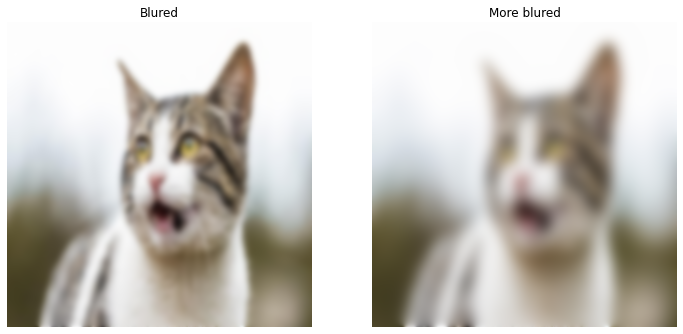

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams['axes.grid'] = False
ax[0].imshow(blured_img)
ax[0].set_title('Blured')
ax[1].imshow(more_blured_img)
ax[1].set_title('More blured')
for ax in fig.axes:
    ax.axis("off")
plt.show()

### Median

In [201]:
%%writefile median.cu

#include <stdio.h>
// kernel

const long int size = 600;
const long int N = size*size;

__global__ void Hello(void)
{

    long int globalIdx = blockDim.x*threadIdx.y+ threadIdx.x;
    //printf("hello from bx = %d\tby = %d\ttx = %d\tty = %d\tgi = %d\n", 
    //    blockIdx.x, blockIdx.y, threadIdx.x, threadIdx.y, globalIdx);
    globalIdx += 1;
}

__global__ void Init(long int n, float * d_a)
{
    int globalIdx = threadIdx.z * blockDim.x * blockDim.y + threadIdx.y * blockDim.x + threadIdx.x;

    if(globalIdx < n) d_a[globalIdx] = globalIdx;
}





__global__ void Median(long int n, float * d_old, float * d_new, float * d_neigh)
{
    int x = blockIdx.x;
    int y = threadIdx.x;
    int globalIdx = x * blockDim.x + y;
    float stay;

    if(globalIdx < n)
    { 
        if((x != 0) && (x !=  size-1))
        {
            if((y != 0) && (y !=  size-1))
            {
                d_neigh[0] = d_old[globalIdx];
             
                d_neigh[1] = d_old[(x - 1) * blockDim.x + y];
             
                d_neigh[2] = d_old[(x - 1) * blockDim.x + y + 1];
                d_neigh[3] = d_old[x * blockDim.x + y + 1 ];
                d_neigh[4] = d_old[(x + 1) * blockDim.x + y + 1];
             
                d_neigh[5] = d_old[(x + 1) * blockDim.x + y ];
             
                d_neigh[6] = d_old[(x + 1) * blockDim.x + y - 1];
                d_neigh[7] = d_old[x * blockDim.x + y - 1];
                d_neigh[8] = d_old[(x - 1) * blockDim.x + y - 1];
             
                // подумать над сортировкой
                
                for(int i = 0; i < 9; ++i) // i - номер прохода
                {            
                    for(int j = 0; j < 9; ++j) // внутренний цикл прохода
                    {     
                        if (d_neigh[j + 1] < d_neigh[j]) 
                        {
                           stay = d_neigh[j];
                           d_neigh[j ] =  d_neigh[j+1];
                           d_neigh[j+1] = stay;
                        }
                   }
                 }
                
                d_new[globalIdx] = d_neigh[4];
                d_old[globalIdx] = d_new[globalIdx];
            }
        }
    }  
}

// CPU code
int main()
{

    float * h_r = (float *)malloc(sizeof(float)*N);
    float * h_g = (float *)malloc(sizeof(float)*N);
    float * h_b = (float *)malloc(sizeof(float)*N);

    float * d_r;
    float * d_g;
    float * d_b;
    float * d_new;
    float * d_neigh;

    cudaMalloc(&d_r, sizeof(float)*N);
    cudaMalloc(&d_g, sizeof(float)*N);
    cudaMalloc(&d_b, sizeof(float)*N);
    cudaMalloc(&d_new, sizeof(float)*N);
    cudaMalloc(&d_neigh, sizeof(float)*9);

    FILE *init_r, *init_g, *init_b, *out_r, *out_g, *out_b;
    init_r = fopen("cat_r.txt","r");
    init_g = fopen("cat_g.txt","r");
    init_b = fopen("cat_b.txt","r");

    out_r = fopen("med_cat_r.txt","w");
    out_g = fopen("med_cat_g.txt","w");
    out_b = fopen("med_cat_b.txt","w");

    
    for(int i=0; i<size; i++)
    {
        for(int j=0; j<size; j++)
        {
            fscanf(init_r, "%f", &h_r[i*size + j]);
            fscanf(init_g, "%f", &h_g[i*size + j]);
            fscanf(init_b, "%f", &h_b[i*size + j]);
        }
    }

    cudaMemcpy(d_r, h_r, sizeof(float)*N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_g, h_g, sizeof(float)*N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeof(float)*N, cudaMemcpyHostToDevice);

    for(int i=0; i<500; i++)
    {
        Median<<<size,size>>>(N, d_r, d_new, d_neigh);
        
        Median<<<size,size>>>(N, d_g, d_new, d_neigh);
        
        Median<<<size,size>>>(N, d_b, d_new, d_neigh);
    }

    cudaMemcpy(h_r, d_r, sizeof(float)*N, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_g, d_g, sizeof(float)*N, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_b, d_b, sizeof(float)*N, cudaMemcpyDeviceToHost);

    cudaDeviceSynchronize();


    for(int i = 0; i < size; i++)
    {
        for(int j = 0; j < size; j++)
        {
            fprintf(out_r, "%f ", h_r[i*size+j]);
            fprintf(out_g, "%f ", h_g[i*size+j]);
            fprintf(out_b, "%f ", h_b[i*size+j]);
        }
        
        fprintf(out_r, "\n"); 
        fprintf(out_g, "\n"); 
        fprintf(out_b, "\n"); 
    }

    cudaDeviceSynchronize();
 
   
    fclose(init_r);
    fclose(init_g);
    fclose(init_b);
    
    fclose(out_r);
    fclose(out_g);
    fclose(out_b);
    
    cudaFree(d_r);
    cudaFree(d_g);
    cudaFree(d_b);
    cudaFree(d_new);
    cudaFree(d_neigh);
 
    free(h_r);
    free(h_g);
    free(h_b);


    return 0;
}

Overwriting median.cu


In [202]:
!nvcc median.cu -o ./out

In [203]:
!./out

In [204]:
with open('med_cat_r.txt', 'r') as file:
   med_cat_r = pd.DataFrame(np.genfromtxt(file,  delimiter=None, skip_header=0))

with open('med_cat_g.txt', 'r') as file:
   med_cat_g = pd.DataFrame(np.genfromtxt(file,  delimiter=None, skip_header=0))

with open('med_cat_b.txt', 'r') as file:
   med_cat_b = pd.DataFrame(np.genfromtxt(file,  delimiter=None, skip_header=0))

In [ ]:
# med_img = np.zeros(img.shape)
# med_img[:,:,0] = np.array(med_cat_r)
# med_img[:,:,1] = np.array(med_cat_g)
# med_img[:,:,2] = np.array(med_cat_b)

In [205]:
more_med_img = np.zeros(img.shape)
more_med_img[:,:,0] = np.array(med_cat_r)
more_med_img[:,:,1] = np.array(med_cat_g)
more_med_img[:,:,2] = np.array(med_cat_b)

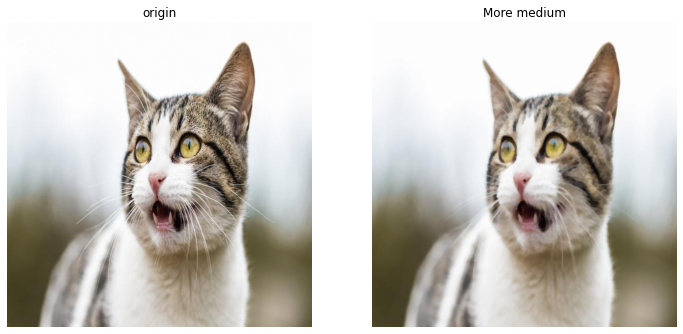

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams['axes.grid'] = False
ax[0].imshow(img)
ax[0].set_title('origin')
ax[1].imshow(more_med_img)
ax[1].set_title('More medium')
for ax in fig.axes:
    ax.axis("off")
plt.show()

## 3) Histogram:


(600, 600)


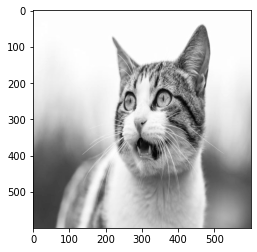

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
from matplotlib import image
import PIL
from PIL import Image, ImageOps
img = Image.open('cat.jpg')
img = img.resize((600, 600), Image.ANTIALIAS)
img = ImageOps.grayscale(img)
img.save('gray_cat.jpg')


img = image.imread('gray_cat.jpg')

img = np.array(img)

plt.imshow(img, cmap = 'gray')
print(img.shape)
plt.show()

In [107]:

gray_cat = pd.DataFrame(img)
gray_cat.to_csv('gray_cat.txt', header=None, index=None, sep=' ')

In [209]:
%%writefile hist.cu

#include <stdio.h>
// kernel

const long int size = 600;
const long int L = size*size;

__global__ void Init(long int n, float * d_a)
{
    int globalIdx = threadIdx.z * blockDim.x * blockDim.y + threadIdx.y * blockDim.x + threadIdx.x;
    float val = 0;
    if(globalIdx < n) d_a[globalIdx] = val;
}



__global__ void Hist(long int n, float * d_img, long int h, float * d_hist)
{
    int globalIdx;

    int hist_id = threadIdx.x; 
    float inp = (float)threadIdx.x , outp = (float)(threadIdx.x + 1) ;

    if(hist_id < h) { 
        for(int i = 0; i < size; i++)
        {
            for(int j = 0; j < size; j++)
            {
                globalIdx = i * size + j;
                if ((inp <= d_img[globalIdx]) && (d_img[globalIdx] < outp) )
                    d_hist[hist_id] += 1;
            }
        }
    }
}


// CPU code
int main()
{

    float * h_gray = (float *)malloc(sizeof(float)*L); 
    float * h_hist = (float *)malloc(sizeof(float)*256);

    float * d_gray;
    float * d_hist;

    cudaMalloc(&d_gray, sizeof(float)*L);
    cudaMalloc(&d_hist, sizeof(float)*256);

    FILE *in_gray , *out_hist;
 
    in_gray = fopen("gray_catty.txt","r");
 
    out_hist = fopen("histogram.txt","w");

   
    for(int i = 0; i < size; i++)
    {
        for(int j = 0; j < size; j++)
        {
            fscanf(in_gray, "%f", &h_gray[i*size+j]);         
        }
    }
 
//    for(int i=0; i<size; i++)
//    {
//        for(int j=0; j<size; j++)
//        {
//            printf("%f", h_gray[i*size+j]);
//        }
//     printf("\n"); 
//    }
     

    cudaMemcpy(d_gray, h_gray, sizeof(float)*L, cudaMemcpyHostToDevice);

    Init<<<1, 256>>>(256, d_hist);
    Hist<<<1, 256>>>(L, d_gray, 256, d_hist);

    cudaMemcpy(h_gray, d_gray, sizeof(float)*L, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_hist, d_hist, sizeof(float)*256, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();



    for(int i=0; i<256; i++)
    {
         fprintf(out_hist, "%f ", h_hist[i]);
    }

    cudaDeviceSynchronize();
    
    fclose(in_gray);
    fclose(out_hist);
   
    cudaFree(d_gray);
    cudaFree(d_hist);
    
    free(h_gray);
    free(h_hist);




    return 0;
}

Overwriting hist.cu


In [210]:
!nvcc hist.cu -o out

In [211]:
!./out

In [212]:
hist=[]
with open('histogram.txt','r') as file:
    for line in file:
        for word in line.split():         
            hist.append(float(word))

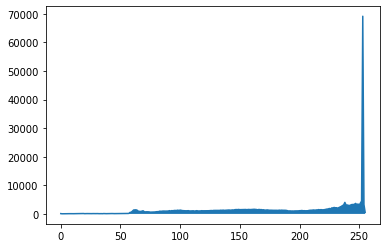

In [213]:
x = np.arange(256)
plt.plot(hist)
plt.fill_between(x, 0, hist)

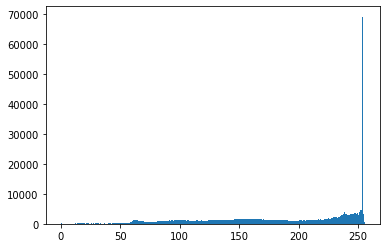

In [114]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('gray_cat.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

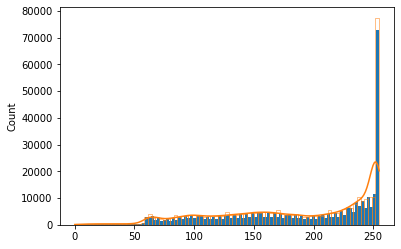

In [113]:
import seaborn as sns
plt.hist(np.array(gray_cat).reshape(-1), bins = 100)
sns.histplot(data=np.array(gray_cat).reshape(-1), kde=True, fill=False)